In [1]:
import torch
import numpy as np
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torch.autograd import Variable
from torch.utils.data import DataLoader

from modules import DropoutExtended, Normalization, HSDBBALoss

In [2]:
class Oracle(torch.nn.Module):
    """Predicts distribution over actions from initial state and successor state
    
    Arguments
    ---------
    state_size  (int): number of dimensions of states
    action_size (int): number of dimensions of actions
    """
    def __init__(self, state_size, action_size, p=0.05, hidden_size=200):
        super(Oracle, self).__init__()
        self.p = p
        self.input_norm = Normalization(2 * state_size)
        self.fc1 = torch.nn.Linear(2 * state_size, hidden_size)
        self.norm1 = torch.nn.BatchNorm1d(hidden_size)
        self.drop1 = DropoutExtended(p=p)
        self.fc2 = torch.nn.Linear(hidden_size, hidden_size)
        self.norm2 = torch.nn.BatchNorm1d(hidden_size)
        self.drop2 = DropoutExtended(p=p)
        self.µ = torch.nn.Linear(hidden_size, action_size)
        self.σ = torch.nn.Linear(hidden_size, action_size)

    def freeze(self):
        """Keeps the same dropout mask for consecutive calls"""
        self.drop1.freeze()
        self.drop2.freeze()

    def unfreeze(self):
        self.drop1.unfreeze()
        self.drop2.unfreeze()

    def forward(self, x, x_):
        """
        >>> oracle = Oracle(...)
        >>> µ, σ = oracle(x, x_)
        
        Arguments
        ---------
        x  (torch.autograd.Variable): initial state
        x_ (torch.autograd.Variable): successor state
        """
        xx_ = torch.cat([x, x_], dim=1)
        x_norm = self.input_norm(xx_)
        a1 = self.drop1(self.norm1(F.elu(self.fc1(x_norm))))
        a2 = self.drop2(self.norm2(F.elu(self.fc2(a1))))
        µ = self.µ(a2)
        σ = F.softplus(self.σ(a2))
        return µ, σ
    
oracle = Oracle(1, 1, p=0.5).cuda()

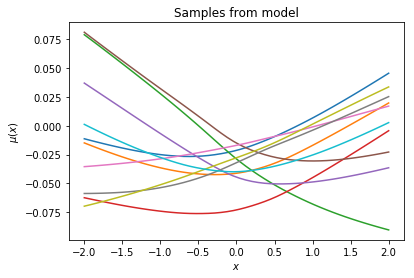

In [3]:
oracle.eval() # This turns of rolling mean updates for normalization and other stuff for training
xs = np.linspace(-2, 2)
for _ in range(10):
    us = []
    oracle.freeze() # This makes predictions deterministic
    for x in xs:
        X = Variable(torch.cuda.FloatTensor([[x]])).cuda()
        X_ = X
        µ, σ = oracle(X, X)
        us.append(µ.cpu().data.numpy()[0])
    plt.plot(xs, us)
plt.title('Samples from model')
plt.xlabel('$x$')
plt.ylabel('$\mu(x)$')
plt.show()

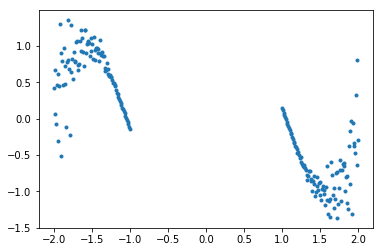

In [4]:
# Let's invent some data, some are missing, some are more noisy
xs = np.concatenate([np.linspace(-2, -1, 100), np.linspace(1, 2, 100)]).astype(np.float32)
ys = np.sin(xs * 3) + 0.5 * np.random.randn(*xs.shape) * (np.abs(xs) - 1) ** 2
ys = ys.astype(np.float32)
plt.plot(xs, ys, '.')
plt.show()
Xs = [np.array([x]) for x in xs]
Ys = [np.array([y]) for y in ys]

In [5]:
# Train the model, this takes some time to get the proper distribution right
loss_fn = HSDBBALoss()
optim = torch.optim.Adam(oracle.parameters())
oracle.unfreeze()
oracle.train()
n_samples = 8
dataloader = DataLoader(list(zip(Xs, Ys)), shuffle=True, batch_size=64)
for _ in range(10000):
    X, Y = map(lambda x: Variable(x.cuda()), next(iter(dataloader)))
    µs, σs = [], []
    for _ in range(n_samples):
        µ, σ = oracle(X, X)
        µs.append(µ)
        σs.append(σ)
    loss = loss_fn(µs, σs, Y)
    oracle.zero_grad()
    loss.backward()
    optim.step()

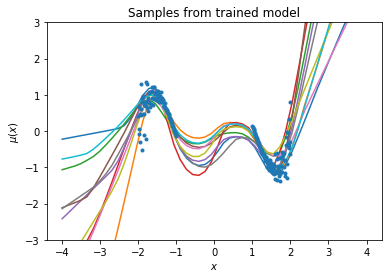

In [6]:
# Let's sample from the trained model
oracle.eval()
xs_ = np.linspace(-4, 4)
for _ in range(10):
    us = []
    oracle.freeze()
    for x in xs_:
        X = Variable(torch.cuda.FloatTensor([[x]])).cuda()
        X_ = X
        µ, σ = oracle(X, X_)
        us.append(µ.cpu().data.numpy()[0])
    plt.plot(xs_, us)
plt.plot(xs, ys, '.')
plt.title('Samples from trained model')
plt.xlabel('$x$')
plt.ylabel('$\mu(x)$')
plt.ylim(-3, 3)
plt.show()

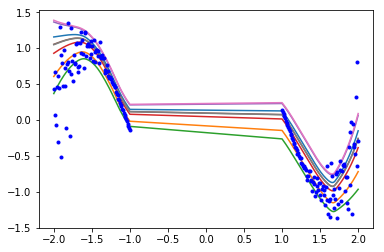

In [7]:
# Drawing many samples gives the maximum a posteriori distribution N(µ(x), σ(x)) which we then can sample from
oracle.eval()
us_µ = []
us_σ = []
n_samples = 32
for x in xs:
    X = Variable(torch.from_numpy(np.array([[x]])).cuda())
    u_µ = 0.0
    u_σ = 0.0
    for _ in range(n_samples):
        µ, σ = oracle(X, X)
        u_µ += µ.cpu().data.numpy()[0] / n_samples
        u_σ += σ.cpu().data.numpy()[0] / n_samples
    us_µ.append(u_µ)
    us_σ.append(u_σ)
us_µ = np.array(us_µ)
us_σ = np.array(us_σ)
for _ in range(8):
    z = np.random.randn()
    plt.plot(xs, us_µ + z * us_σ)
plt.plot(xs, ys, 'b.')
plt.show()